In [3]:
#Importando las librerias necesarias

from keras.preprocessing.image import ImageDataGenerator
from matplotlib.image import imread
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow as tf
import numpy as np
import shutil
import keras as kr
import cv2
import os

In [2]:
#Copiando imagenes de la carpeta fuente a la carpeta destino (imagenes no verificables)

carpeta_fuente_0 = 'IMAGES/0'
carpeta_destino_0 = 'TRAIN_IMGS/0'

imagenes = os.listdir(carpeta_fuente_0)

for i, nombreimg in enumerate(imagenes):
    if i < 1001:
        #Copia de la carpeta fuente a la carpoeta destino
        shutil.copy(carpeta_fuente_0+'/'+nombreimg, carpeta_destino_0+'/'+nombreimg)

In [3]:
#Copiando imagenes de la carpeta fuente a la carpeta destino (imagenes verificables)

carpeta_fuente_1 = 'IMAGES/1'
carpeta_destino_1 = 'TRAIN_IMGS/1'

imagenes = os.listdir(carpeta_fuente_1)

for i, nombreimg in enumerate(imagenes):
    if i < 1001:
        #Copia de la carpeta fuente a la carpoeta destino
        shutil.copy(carpeta_fuente_1+'/'+nombreimg, carpeta_destino_1+'/'+nombreimg)

Found 1602 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


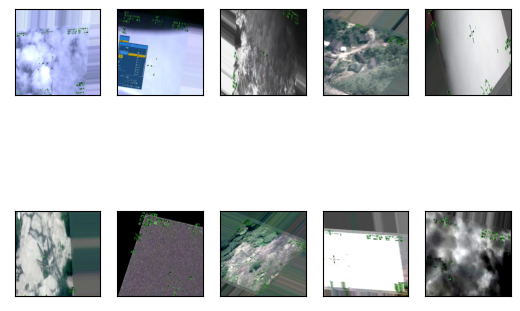

In [44]:
#Creacion del dataset y aumento de datos

datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    width_shift_range = 0.25,
    height_shift_range = 0.25,
    shear_range = 15,
    zoom_range = [0.5, 1.5],
    validation_split=0.2 
)

#Creacion de los sets de entrenamiento y pruebas

data_gen_entrenamiento = datagen.flow_from_directory('TRAIN_IMGS', target_size=(224,224),
                                                     batch_size=32, shuffle=True, subset='training')
data_gen_pruebas = datagen.flow_from_directory('TRAIN_IMGS', target_size=(224,224),
                                                     batch_size=32, shuffle=True, subset='validation')

#Impresion de 10 imagenes de validacion

for imagen, etiqueta in data_gen_entrenamiento:
  for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imagen[i])
  break
plt.show()

In [74]:
#Clonado del modelo

url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
mobilenetv2 = hub.KerasLayer(url, input_shape=(224,224,3))

#Congelamiento nde las capas pre entrenadas

mobilenetv2.trainable = False

#Modificacion de la ultima capa del modelo

modelo = tf.keras.Sequential([
    mobilenetv2,
    tf.keras.layers.Dense(2, activation='softmax')
])

modelo.summary()

#Compílacion del modelo

modelo.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_6 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_6 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [75]:
EPOCAS = 15

historial = modelo.fit(
    data_gen_entrenamiento, epochs=EPOCAS, batch_size=32,
    validation_data=data_gen_pruebas
)

Epoch 1/15
51/51 [==============================] - 83s 2s/step - loss: 0.5739 - accuracy: 0.7135 - val_loss: 0.4402 - val_accuracy: 0.7750
Epoch 2/15
51/51 [==============================] - 76s 1s/step - loss: 0.3479 - accuracy: 0.8464 - val_loss: 0.3742 - val_accuracy: 0.8550
Epoch 3/15
51/51 [==============================] - 78s 2s/step - loss: 0.2957 - accuracy: 0.8745 - val_loss: 0.3365 - val_accuracy: 0.8700
Epoch 4/15
51/51 [==============================] - 79s 2s/step - loss: 0.2765 - accuracy: 0.8820 - val_loss: 0.2995 - val_accuracy: 0.8775
Epoch 5/15
51/51 [==============================] - 79s 2s/step - loss: 0.2620 - accuracy: 0.8920 - val_loss: 0.3290 - val_accuracy: 0.8550
Epoch 6/15
51/51 [==============================] - 79s 2s/step - loss: 0.2344 - accuracy: 0.9120 - val_loss: 0.3008 - val_accuracy: 0.8700
Epoch 7/15
51/51 [==============================] - 80s 2s/step - loss: 0.2384 - accuracy: 0.8983 - val_loss: 0.3541 - val_accuracy: 0.8550
Epoch 8/15
51/51 [==

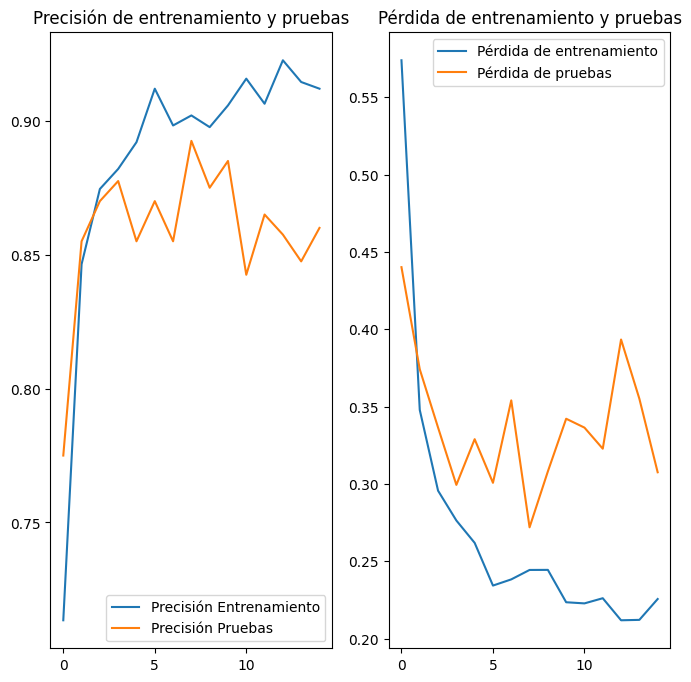

In [77]:
#Graficas de precisión

acc = historial.history['accuracy']
val_acc = historial.history['val_accuracy']

loss = historial.history['loss']
val_loss = historial.history['val_loss']

rango_epocas = range(15)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(rango_epocas, acc, label='Precisión Entrenamiento')
plt.plot(rango_epocas, val_acc, label='Precisión Pruebas')
plt.legend(loc='lower right')
plt.title('Precisión de entrenamiento y pruebas')

plt.subplot(1,2,2)
plt.plot(rango_epocas, loss, label='Pérdida de entrenamiento')
plt.plot(rango_epocas, val_loss, label='Pérdida de pruebas')
plt.legend(loc='upper right')
plt.title('Pérdida de entrenamiento y pruebas')
plt.show()

In [78]:
#Pruebas manuales del modelo

def categorizar(path):
  
  img = imread(path).astype(float)/255

  img = cv2.resize(img, (224,224))
  prediccion = modelo.predict(img.reshape(-1, 224, 224, 3))
  return np.argmax(prediccion[0], axis=-1)

url = 'frame44.jpg' 
prediccion = categorizar (url)
print(prediccion)

1/1 [==============================] - 1s 1s/step
1


In [79]:
for i in range (2174,2352):

    print("Imagen "+str(i), categorizar('VIDEOFRAMESEXTRACTED/frame'+str(i)+'.jpg'))

1/1 [==============================] - 0s 65ms/step
Imagen 2174 0
1/1 [==============================] - 0s 102ms/step
Imagen 2175 0
1/1 [==============================] - 0s 92ms/step
Imagen 2176 0
1/1 [==============================] - 0s 88ms/step
Imagen 2177 0
1/1 [==============================] - 0s 80ms/step
Imagen 2178 0
1/1 [==============================] - 0s 95ms/step
Imagen 2179 0
1/1 [==============================] - 0s 79ms/step
Imagen 2180 0
1/1 [==============================] - 0s 88ms/step
Imagen 2181 0
1/1 [==============================] - 0s 70ms/step
Imagen 2182 0
1/1 [==============================] - 0s 81ms/step
Imagen 2183 0
1/1 [==============================] - 0s 117ms/step
Imagen 2184 0
1/1 [==============================] - 0s 97ms/step
Imagen 2185 0
1/1 [==============================] - 0s 75ms/step
Imagen 2186 0
1/1 [==============================] - 0s 120ms/step
Imagen 2187 0
1/1 [==============================] - 0s 130ms/step
Imagen 2188 0
1/1 [=

In [4]:
#Guardamos el modelo y sus parametros 

modelo.save('IMAGESELECTORV.2')

NameError: name 'modelo' is not defined

In [5]:
#Probando que el modelo se pueda cargar nuevamente

modelo2 = kr.models.load_model('IMAGESELECTORV.2')


In [7]:
#Probando que haga predicciones correctamente

def categorizar2(path):
  
  img = imread(path).astype(float)/255

  img = cv2.resize(img, (224,224))
  prediccion = modelo2.predict(img.reshape(-1, 224, 224, 3))
  return np.argmax(prediccion[0], axis=-1)

url2 = 'frame14.jpg' 
prediccion2 = categorizar2 (url2)
print(prediccion2)

1/1 [==============================] - 0s 68ms/step
1
